# Import Libraries

In [110]:
import json
import graphviz 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# variable for consistent random selections
RANDOM_STATE = 21

%matplotlib inline

# Load data

In [111]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [112]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

# Data Exploration

### Look for missing values

In [113]:
# Missing values
(df.count() - df.count().max()).abs()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Check values to make sure they make sense

In [114]:
# All potential categorical values
categories = {}
for col in df:
    if df[col].dtype == object:
        categories[col] = list(df[col].unique())

print(json.dumps(categories, indent=2))

{
  "job": [
    "management",
    "technician",
    "entrepreneur",
    "blue-collar",
    "unknown",
    "retired",
    "admin.",
    "services",
    "self-employed",
    "unemployed",
    "housemaid",
    "student"
  ],
  "marital": [
    "married",
    "single",
    "divorced"
  ],
  "education": [
    "tertiary",
    "secondary",
    "unknown",
    "primary"
  ],
  "default": [
    "no",
    "yes"
  ],
  "housing": [
    "yes",
    "no"
  ],
  "loan": [
    "no",
    "yes"
  ],
  "contact": [
    "unknown",
    "cellular",
    "telephone"
  ],
  "month": [
    "may",
    "jun",
    "jul",
    "aug",
    "oct",
    "nov",
    "dec",
    "jan",
    "feb",
    "mar",
    "apr",
    "sep"
  ],
  "poutcome": [
    "unknown",
    "failure",
    "other",
    "success"
  ],
  "y": [
    "no",
    "yes"
  ]
}


In [115]:
# Numerical values
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Correlation analysis

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


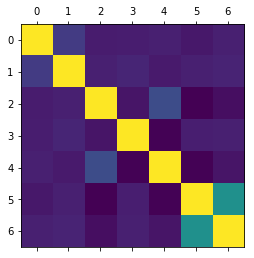

In [116]:
plt.matshow(df.corr())
df.corr()

# Check for target balance

In [144]:
print(5289.0 / X.shape[0])
df[['y', 'poutcome']].groupby('y').count()

0.11698480458295547


,poutcome
y,
no,39922
yes,5289


# Create datasets

In [183]:
# Create one-hot encodings of categorical variables
categorical_columns = ['job', 'marital', 'education', 'default',
                       'housing','loan','contact','month','poutcome']
X = pd.get_dummies(df, columns=categorical_columns)
X_df = X

# Get y labels as 1 or 0
y = np.where(X['y'] == 'yes', 1, 0)
X.drop(columns=['y'], inplace=True)
cols = X.columns

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Helper functions

In [160]:
def plot_curves(title, xlabel, ylabel, train_set, test_set, metric_label, ylim_min=0.75):
    plt.plot(train_set, linewidth=3, label='Training ' + metric_label)
    plt.plot(test_set, linewidth=3, label='Test ' + metric_label)
    plt.legend()
    plt.title(title)
    plt.ylim(ylim_min, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()
    
def learning_curve(clf_name, clf, step=5):
    train_auc, test_auc = [], []
    x_step = []
    for i in range(step, 101, step):
        pct = 1.0 * i / 100
        upper = int(X_train.shape[0] * pct) - 1
        X_train_sub = X_train[:upper]
        y_train_sub = y_train[:upper]
        x_step.append(upper)
        
        clf = clf.fit(X_train_sub, y_train_sub)
        train_auc.append(roc_auc_score(y_train_sub, clf.predict_proba(X_train_sub)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        
    plt.plot(np.array(x_step), np.array(train_auc), label='Training AUC')
    plt.plot(np.array(x_step), np.array(test_auc), label='Test AUC')
    plt.legend()
    plt.title('Bank ' + clf_name + ' Learning Curves')
    plt.ylim(0.50, 1.0)
    plt.xlabel('# of Samples')
    plt.ylabel('ROC AUC')
    plt.figure(figsize=(12,12))
    plt.show()

# Decision Tree

In [120]:
dt_clf = tree.DecisionTreeClassifier(max_depth=6, criterion='entropy')
dt_clf = dt_clf.fit(X_train, y_train)

### Plot tree

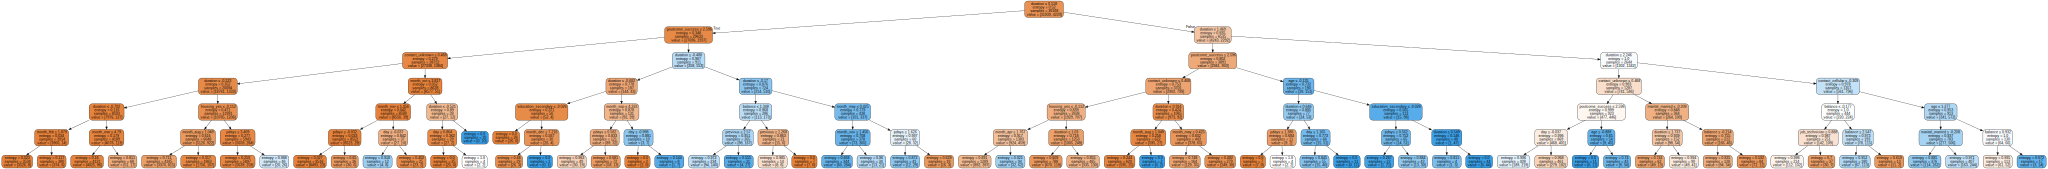

In [121]:
dot_data = tree.export_graphviz(dt_clf, out_file=None)
dot_data = tree.export_graphviz(dt_clf, out_file=None, 
                         feature_names=X_df.columns,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

### Model complexity curves

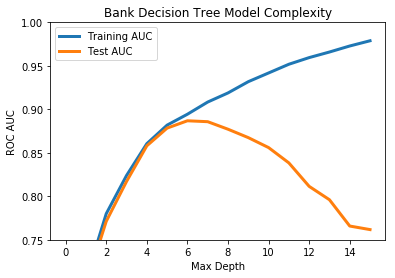

<Figure size 864x864 with 0 Axes>

In [142]:
max_depth = 16
train_auc, test_auc = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1, max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy')
    clf = clf.fit(X_train, y_train)
    train_auc[i] = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    test_auc[i] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

plot_curves('Bank Decision Tree Model Complexity', 'Max Depth', 'ROC AUC', train_auc, test_auc, 'AUC')

### Learning curves

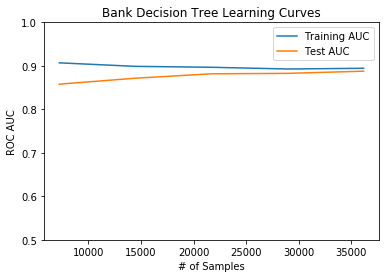

<Figure size 864x864 with 0 Axes>

In [143]:
learning_curve('Bank Decision Tree', dt_clf)

# Neural Network (Multi-layer perceptron)

In [170]:
mlp_clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu',
                        learning_rate='constant', random_state=RANDOM_STATE,
                        hidden_layer_sizes=(30), max_iter=4)
mlp_clf = mlp_clf.fit(X_train, y_train)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Model complexity curves

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimize

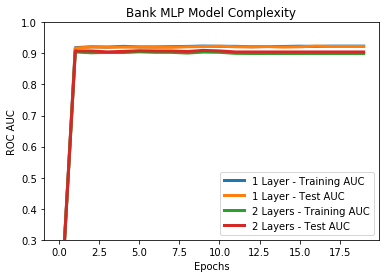

<Figure size 864x864 with 0 Axes>

In [145]:
epochs = 20
train_auc1, test_auc1 = np.zeros(epochs), np.zeros(epochs)
train_auc2, test_auc2 = np.zeros(epochs), np.zeros(epochs)
for i in range(1, epochs):
    # Single layer
    clf1 = MLPClassifier(solver='adam', alpha=0.1, activation='relu', batch_size=20,
                        learning_rate='constant', random_state=RANDOM_STATE,
                        hidden_layer_sizes=(30), max_iter=i)
    clf1 = clf1.fit(X_train, y_train)
    train_auc1[i] = roc_auc_score(y_train, clf1.predict_proba(X_train)[:,1])
    test_auc1[i] = roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])

    # Two layers
    clf2 = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                        learning_rate='constant', random_state=1,
                        hidden_layer_sizes=(30, 30), max_iter=i)
    clf2 = clf2.fit(X_train, y_train)
    train_auc2[i] = roc_auc_score(y_train, clf2.predict_proba(X_train)[:,1])
    test_auc2[i] = roc_auc_score(y_test, clf2.predict_proba(X_test)[:,1])

# Create plot
plt.plot(train_auc1, linewidth=3, label='1 Layer - Training AUC')
plt.plot(test_auc1, linewidth=3, label='1 Layer - Test AUC')
plt.plot(train_auc2, linewidth=3, label='2 Layers - Training AUC')
plt.plot(test_auc2, linewidth=3, label='2 Layers - Test AUC')
plt.legend()
plt.title('Bank MLP Model Complexity')
plt.ylim(0.3, 1.0)
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

# Learning curves

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


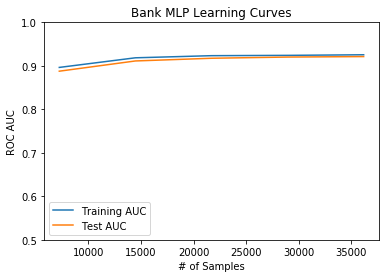

<Figure size 864x864 with 0 Axes>

In [151]:
learning_curve('MLP', mlp)

# Boosting

In [175]:
boost_clf = GradientBoostingClassifier(max_depth=10, n_estimators=100)
boost_clf = boost_clf.fit(X_train, y_train)

### Model complexity curves

Depth 5 done.
Depth 7 done.
Depth 9 done.


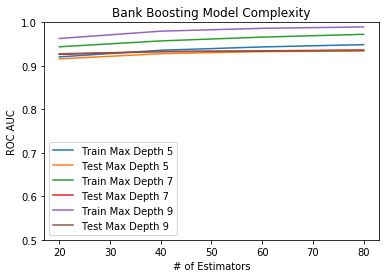

<Figure size 864x864 with 0 Axes>

In [152]:
n_estimators, n_step = (100, 20)
min_depth, max_depth = (5, 10)
for i in range(min_depth, max_depth, 2):
    train_auc, test_auc = [], []
    x_step = []
    for j in range(n_step, n_estimators, n_step):
        clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
        clf = clf.fit(X_train, y_train)
        x_step.append(j)
        
        train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
    plt.plot(np.array(x_step), np.array(train_auc), label='Train Max Depth %d' % i)
    plt.plot(np.array(x_step), np.array(test_auc), label='Test Max Depth %d' % i)
    print('Depth %s done.' % i)

plt.legend()
plt.title('Bank Boosting Model Complexity')
plt.ylim(0.5, 1.0)
plt.xlabel('# of Estimators')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

### Learning curves

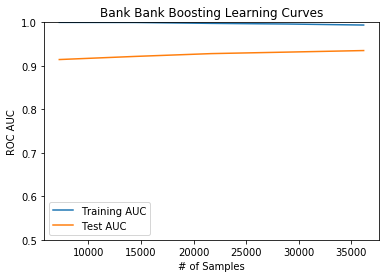

<Figure size 864x864 with 0 Axes>

In [153]:
learning_curve('Boosting', GradientBoostingClassifier(max_depth=9, n_estimators=100))

# Support Vector Machines

In [168]:
svm_clf = SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)
# svm_clf = svm_clf.fit(X_train, y_train)
# roc_auc_score(y_test, svm_clf.predict_proba(X_test)[:,1])

### Model complexity

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=21).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=31).  Consider pre-processing your data with Standard

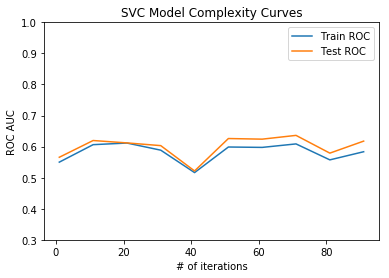

<Figure size 864x864 with 0 Axes>

In [99]:
# mm_scaler = MinMaxScaler().fit(X)
# X_min_max = mm_scaler.transform(X)

# X_mm_train, X_mm_test, y_mm_train, y_mm_test = train_test_split(X_min_max, y, test_size=0.2, random_state=RANDOM_STATE)

max_iter, step = (100, 10)
train_auc, test_auc = [], []
x_step = []
for i in range(1, max_iter, step):
    clf = SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True, max_iter=i)
    clf = clf.fit(X_train, y_train)
    x_step.append(i)

    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

plt.plot(np.array(x_step), np.array(train_auc), label='Train ROC')
plt.plot(np.array(x_step), np.array(test_auc), label='Test ROC')
plt.legend()
plt.title('SVC Model Complexity Curves')
plt.ylim(0.3, 1.0)
plt.xlabel('# of iterations')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

### Model selection

In [166]:
kernels = (('linear', 0), ('poly', 2), ('poly', 3), ('rbf', 0))
for k in kernels:
    clf = SVC(kernel=k[0], degree=k[1], random_state=RANDOM_STATE, probability=True)
    clf = clf.fit(X_train[:20000], y_train[:20000])

    train_auc = roc_auc_score(y_train[:20000], clf.predict_proba(X_train[:20000])[:,1])
    test_auc = roc_auc_score(y_test[:4000], clf.predict_proba(X_test[:4000])[:,1])
    
    print(k, {'train_auc': train_auc, 'test_auc': test_auc})

('linear', 0) {'train_auc': 0.905543330173463, 'test_auc': 0.9118986754014299}
('poly', 2) {'train_auc': 0.8554671975300431, 'test_auc': 0.8178090246321331}
('poly', 3) {'train_auc': 0.9605801661174266, 'test_auc': 0.8880295933843255}
('rbf', 0) {'train_auc': 0.9507714072196594, 'test_auc': 0.9190541321469398}


### Learning curves

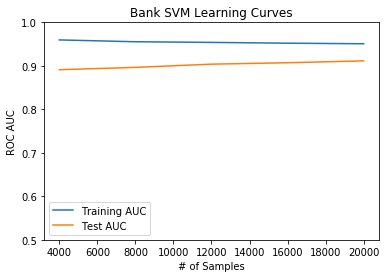

<Figure size 864x864 with 0 Axes>

In [169]:
X_train_svm = X_train[:20000]
y_train_svm = y_train[:20000]

def learning_curve_svm(clf_name, clf, step=20):
    train_auc, test_auc = [], []
    x_step = []
    for i in range(step, 101, step):
        pct = 1.0 * i / 100
        upper = int(X_train_svm.shape[0] * pct) - 1
        X_train_sub = X_train_svm[:upper]
        y_train_sub = y_train_svm[:upper]
        x_step.append(upper)
        
        clf = clf.fit(X_train_sub, y_train_sub)
        train_auc.append(roc_auc_score(y_train_sub, clf.predict_proba(X_train_sub)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        
    plt.plot(np.array(x_step), np.array(train_auc), label='Training AUC')
    plt.plot(np.array(x_step), np.array(test_auc), label='Test AUC')
    plt.legend()
    plt.title('Bank ' + clf_name + ' Learning Curves')
    plt.ylim(0.50, 1.0)
    plt.xlabel('# of Samples')
    plt.ylabel('ROC AUC')
    plt.figure(figsize=(12,12))
    plt.show()
    
learning_curve_svm('SVM', svm_clf)

# K-Nearest Neighbors

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors=20)

### Model complexity

1 neighbors
21 neighbors
41 neighbors
61 neighbors
81 neighbors


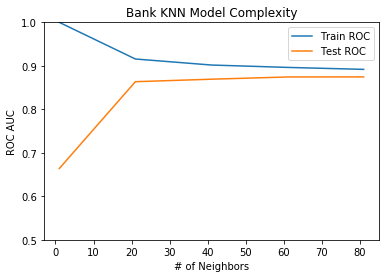

<Figure size 864x864 with 0 Axes>

In [157]:
max_neighbors, step = (87, 20)
train_auc, test_auc = [], []
x_step = []
for i in range(1, max_neighbors, step):
    print('%d neighbors' % i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf = clf.fit(X_train, y_train)
    x_step.append(i)

    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

plt.plot(np.array(x_step), np.array(train_auc), label='Train ROC')
plt.plot(np.array(x_step), np.array(test_auc), label='Test ROC')
plt.legend()
plt.title('Bank KNN Model Complexity')
plt.ylim(0.5, 1.0)
plt.xlabel('# of Neighbors')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

### Learning curves

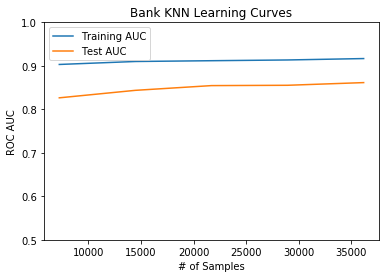

<Figure size 864x864 with 0 Axes>

In [161]:
learning_curve('KNN', knn_clf, step=20)

# Summary of all classifiers

In [195]:
from IPython.display import HTML, display
import tabulate

classifiers = [('Decision Tree', dt_clf), ('Multi-Layer Perceptron', mlp_clf), ('Boosting', boost_clf),
               ('K-Nearest Neighbor', knn_clf), ('Support Vector Machine', SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True, max_iter=500))]
table = [['Classifier', 'Train Accuracy', 'Test Accuracy', 'Train F1 Score', 'Test F1 Score',
          'Train ROC AUC', 'Test ROC AUC']]
for clf_name, clf in classifiers:
    clf = clf.fit(X_train, y_train)
    y_train_prob = clf.predict_proba(X_train)[:,1]
    y_train_hat = np.where(y_train_prob > 0.5, 1, 0)

    train_accuracy = accuracy_score(y_train, y_train_hat)
    train_f1 = f1_score(y_train, y_train_hat, average='macro')
    train_roc = roc_auc_score(y_train, y_train_prob)

    y_test_prob = clf.predict_proba(X_test)[:,1]
    y_test_hat = np.where(y_test_prob > 0.5, 1, 0)

    test_accuracy = accuracy_score(y_test, y_test_hat)
    test_f1 = f1_score(y_test, y_test_hat, average='macro')
    test_roc = roc_auc_score(y_test, y_test_prob)
    
    print([clf_name, train_accuracy, test_accuracy, train_f1, test_f1, train_roc, test_roc])
    table.append([clf_name, train_accuracy, test_accuracy, train_f1, test_f1, train_roc, test_roc])

# Display as table    
display(HTML(tabulate.tabulate(table, tablefmt='html')))

['Decision Tree', 0.9065195753151958, 0.8973791883224593, 0.7221914731239635, 0.6968223497374839, 0.8943794090045039, 0.8886631143065808]


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['Multi-Layer Perceptron', 0.9050541915505419, 0.9033506579674887, 0.70814640584703, 0.7033771605748181, 0.9218822049430049, 0.9191292108939044]
['Boosting', 0.9878345498783455, 0.9022448302554462, 0.9692352268900858, 0.745482042406436, 0.9975225444347458, 0.9325124852575876]
['K-Nearest Neighbor', 0.8998562264985622, 0.8928452947030853, 0.6503852046567874, 0.6285347293802551, 0.9167538504525848, 0.861472492253586]


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


['Support Vector Machine', 0.8301260783012607, 0.824947473183678, 0.547494158823695, 0.544434452708021, 0.5386718908800724, 0.5274386136577964]


Classifier,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
Decision Tree,0.9065195753151958,0.8973791883224593,0.7221914731239635,0.6968223497374839,0.8943794090045039,0.8886631143065808
Multi-Layer Perceptron,0.9050541915505419,0.9033506579674887,0.70814640584703,0.7033771605748181,0.9218822049430049,0.9191292108939044
Boosting,0.9878345498783455,0.9022448302554462,0.9692352268900858,0.745482042406436,0.9975225444347458,0.9325124852575876
K-Nearest Neighbor,0.8998562264985622,0.8928452947030853,0.6503852046567874,0.6285347293802551,0.9167538504525848,0.861472492253586
Support Vector Machine,0.8301260783012607,0.824947473183678,0.547494158823695,0.544434452708021,0.5386718908800724,0.5274386136577964


In [196]:
clf = SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)
clf = clf.fit(X_train, y_train)
y_train_prob = clf.predict_proba(X_train)[:,1]
y_train_hat = np.where(y_train_prob > 0.5, 1, 0)

train_accuracy = accuracy_score(y_train, y_train_hat)
train_f1 = f1_score(y_train, y_train_hat, average='macro')
train_roc = roc_auc_score(y_train, y_train_prob)

y_test_prob = clf.predict_proba(X_test)[:,1]
y_test_hat = np.where(y_test_prob > 0.5, 1, 0)

test_accuracy = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat, average='macro')
test_roc = roc_auc_score(y_test, y_test_prob)

print(['Support Vector Machine', train_accuracy, test_accuracy, train_f1, test_f1, train_roc, test_roc])

['Support Vector Machine', 0.9199015704490157, 0.9018024991706293, 0.7599013923507119, 0.7022708464954039, 0.9464789824472609, 0.9151673721753066]


# Feature importances

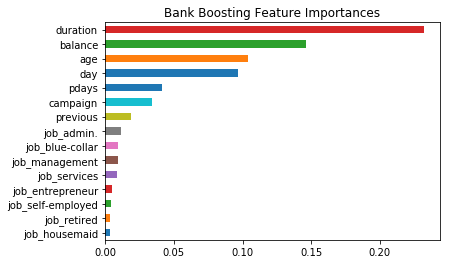

In [178]:
clf = boost_clf
feature_importances = pd.Series(clf.feature_importances_, index=cols)
feature_importances = feature_importances.head(15).sort_values()
feature_importances.plot('barh', title='Bank Boosting Feature Importances')

,duration,balance,age,day,pdays,campaign,previous,y
duration,1.000000,0.021560,-0.004648,-0.030206,-0.001565,-0.084570,0.001203,0.394521
balance,0.021560,1.000000,0.097783,0.004503,0.003435,-0.014578,0.016674,0.052838
age,-0.004648,0.097783,1.000000,-0.009120,-0.023758,0.004760,0.001288,0.025155
day,-0.030206,0.004503,-0.009120,1.000000,-0.093044,0.162490,-0.051710,-0.028348
pdays,-0.001565,0.003435,-0.023758,-0.093044,1.000000,-0.088628,0.454820,0.103621
campaign,-0.084570,-0.014578,0.004760,0.162490,-0.088628,1.000000,-0.032855,-0.073172
previous,0.001203,0.016674,0.001288,-0.051710,0.454820,-0.032855,1.000000,0.093236
y,0.394521,0.052838,0.025155,-0.028348,0.103621,-0.073172,0.093236,1.000000


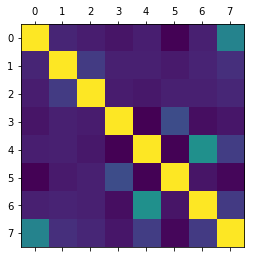

In [187]:
# Correlation Analysis
X_df = pd.get_dummies(df, columns=categorical_columns)
X_df['y'] = np.where(X_df['y'] == 'yes', 1, 0)
X_df = X_df[['duration', 'balance', 'age', 'day', 'pdays', 'campaign', 'previous', 'y']]

plt.matshow(X_df.corr())
X_df.corr()

In [190]:
mlp_clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu',
                        learning_rate='constant', random_state=RANDOM_STATE,
                        hidden_layer_sizes=(30), max_iter=4)
mlp_clf = mlp_clf.fit(X_train, y_train)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
mlp